In [1]:
import os
import pandas as pd

# Function to read all TSV files in a folder and create a dictionary holding the maximum index and sentences for each File Path
def create_index_dict(folder):
    file_dict = {}
    for file_name in os.listdir(folder):
        if file_name.endswith('.tsv'):
            file_path = os.path.join(folder, file_name)
            df = pd.read_csv(file_path, sep='\t')
            for file, group in df.groupby('File Name'):
                max_index = group['Index'].max()
                sentences = group[['Index', 'Sentence']].set_index('Index')['Sentence'].to_dict()
                file_dict[file] = {'max_index': max_index, 'sentences': sentences}
    return file_dict

# Folder paths for KSS, Gemini, ChatGPT, KSSDS, and KSSDS (w/o length filter)
kiwi_folder = './Validation/JupyterKiwiValidation/'                  # Folder for Kiwi model
kss_folder = './Validation/JupyterKSSValidation/'                    # Folder for KSS model
gemini_folder = './Validation/JupyterGeminiValidation/'              # Folder for Gemini model
chatgpt_folder = './Validation/JupyterChatGPTValidation/'            # Folder for ChatGPT model
kssds_folder = './Validation/JupyterKSSDSValidationPhraseDetection/' # Folder for the fine-tuned T5 model (KSSDS)
nolen_folder = './Validation/JupyterNoLenValidation/'                # Folder for KSSDS (w/o length filter)

# Create dictionaries for each model
kiwi_dict = create_index_dict(kiwi_folder)
kss_dict = create_index_dict(kss_folder)
gemini_dict = create_index_dict(gemini_folder)
chatgpt_dict = create_index_dict(chatgpt_folder)
kssds_dict = create_index_dict(kssds_folder)
nolen_dict = create_index_dict(nolen_folder)

# Print how many files were loaded for each model
print(f"Kiwi: {len(kiwi_dict)} files loaded")
print(f"KSS: {len(kss_dict)} files loaded")
print(f"Gemini: {len(gemini_dict)} files loaded")
print(f"ChatGPT: {len(chatgpt_dict)} files loaded")
print(f"KSSDS: {len(kssds_dict)} files loaded")
print(f"KSSDS (w/o length filter): {len(nolen_dict)} files loaded")


Kiwi: 257 files loaded
KSS: 257 files loaded
Gemini: 257 files loaded
ChatGPT: 257 files loaded
KSSDS: 257 files loaded
KSSDS (w/o length filter): 257 files loaded


In [2]:

import re
punctuation_regex = re.compile(r'[.!?]$')
# Function to count the total number of sentences for each model

def count_total_sentences_with_nan(model_dict):
    total_sentences = 0
    punc_sentences = 0
    nan_sentences = 0
    for file_path, file_data in model_dict.items():
        for sentence in file_data['sentences'].values():
            if pd.isna(sentence):  # Count NaN (blank) sentences
                nan_sentences += 1
                # print(f"Non-string sentence found in {file_path}: {sentence} (type: {type(sentence)})")
                continue
            if isinstance(sentence, str):  # Count valid sentences
                total_sentences += 1
                if punctuation_regex.search(sentence):  # Count sentences ending with punctuation
                    punc_sentences += 1
    return total_sentences, punc_sentences, nan_sentences


# Calculate total, punctuation-ending, and NaN sentence counts for each model
total_sentences_kiwi, punc_sentences_kiwi, nan_sentences_kiwi = count_total_sentences_with_nan(kiwi_dict)
total_sentences_kss, punc_sentences_kss, nan_sentences_kss = count_total_sentences_with_nan(kss_dict)
total_sentences_gemini, punc_sentences_gemini, nan_sentences_gemini = count_total_sentences_with_nan(gemini_dict)
total_sentences_chatgpt, punc_sentences_chatgpt, nan_sentences_chatgpt = count_total_sentences_with_nan(chatgpt_dict)
total_sentences_ours, punc_sentences_ours, nan_sentences_ours = count_total_sentences_with_nan(kssds_dict)
total_sentences_nolen, punc_sentences_nolen, nan_sentences_nolen = count_total_sentences_with_nan(nolen_dict)

# Print total sentence counts for each model
print(f"Punc/Total sentences for Kiwi: {punc_sentences_kiwi}/{total_sentences_kiwi}")
print(f"Punc/Total sentences for KSS: {punc_sentences_kss}/{total_sentences_kss}")
print(f"Punc/Total sentences for Gemini: {punc_sentences_gemini}/{total_sentences_gemini}")
print(f"Punc/Total sentences for ChatGPT: {punc_sentences_chatgpt}/{total_sentences_chatgpt}")
print(f"Punc/Total sentences for KSSDS: {punc_sentences_ours}/{total_sentences_ours}")
print(f"Punc/Total sentences for KSSDS(w/o length filter): {punc_sentences_nolen}/{total_sentences_nolen}")

# Calculate and print the ratio of sentences ending with punctuation for each model
def calculate_punctuation_ratio(total_sentences, punc_sentences):
    return ((punc_sentences / total_sentences) * 100) if total_sentences > 0 else 0

print(f"\nKiwi model punctuation ratio: {calculate_punctuation_ratio(total_sentences_kiwi, punc_sentences_kiwi):.2f}%")
print(f"KSS model punctuation ratio: {calculate_punctuation_ratio(total_sentences_kss, punc_sentences_kss):.2f}%")
print(f"Gemini model punctuation ratio: {calculate_punctuation_ratio(total_sentences_gemini, punc_sentences_gemini):.2f}%")
print(f"ChatGPT model punctuation ratio: {calculate_punctuation_ratio(total_sentences_chatgpt, punc_sentences_chatgpt):.2f}%")
print(f"KSSDS model punctuation ratio: {calculate_punctuation_ratio(total_sentences_ours, punc_sentences_ours):.2f}%")
print(f"KSSDS(w/o length filter) model punctuation ratio: {calculate_punctuation_ratio(total_sentences_nolen, punc_sentences_nolen):.2f}%")

Punc/Total sentences for Kiwi: 18224/33188
Punc/Total sentences for KSS: 16911/29874
Punc/Total sentences for Gemini: 17388/31473
Punc/Total sentences for ChatGPT: 28789/31226
Punc/Total sentences for KSSDS: 17874/36048
Punc/Total sentences for KSSDS(w/o length filter): 17965/35073

Kiwi model punctuation ratio: 54.91%
KSS model punctuation ratio: 56.61%
Gemini model punctuation ratio: 55.25%
ChatGPT model punctuation ratio: 92.20%
KSSDS model punctuation ratio: 49.58%
KSSDS(w/o length filter) model punctuation ratio: 51.22%


In [3]:
# Function to calculate sentence lengths for each model
def calculate_sentence_lengths(model_dict):
    sentence_lengths = []
    for file_path, file_data in model_dict.items():
        for sentence in file_data['sentences'].values():
            if pd.isna(sentence):
                continue
            sentence_lengths.append(len(sentence))  # Measure the length of each sentence (in characters)
    return sentence_lengths

# Calculate sentence lengths for each model
kiwi_lengths = calculate_sentence_lengths(kiwi_dict)
kss_lengths = calculate_sentence_lengths(kss_dict)
gemini_lengths = calculate_sentence_lengths(gemini_dict)
chatgpt_lengths = calculate_sentence_lengths(chatgpt_dict)
ours_lengths = calculate_sentence_lengths(kssds_dict)
nolen_lengths = calculate_sentence_lengths(nolen_dict)

# Print some statistics about sentence lengths
print(f"Kiwi: Average sentence length: {sum(kiwi_lengths)/len(kiwi_lengths):.2f}")
print(f"KSS: Average sentence length: {sum(kss_lengths)/len(kss_lengths):.2f}")
print(f"Gemini: Average sentence length: {sum(gemini_lengths)/len(gemini_lengths):.2f}")
print(f"ChatGPT: Average sentence length: {sum(chatgpt_lengths)/len(chatgpt_lengths):.2f}")
print(f"KSSDS: Average sentence length: {sum(ours_lengths)/len(ours_lengths):.2f}")
print(f"KSSDS (w/o length filter): Average sentence length: {sum(nolen_lengths)/len(nolen_lengths):.2f}")


Kiwi: Average sentence length: 26.82
KSS: Average sentence length: 29.91
Gemini: Average sentence length: 28.32
ChatGPT: Average sentence length: 28.88
KSSDS: Average sentence length: 24.61
KSSDS (w/o length filter): Average sentence length: 25.32


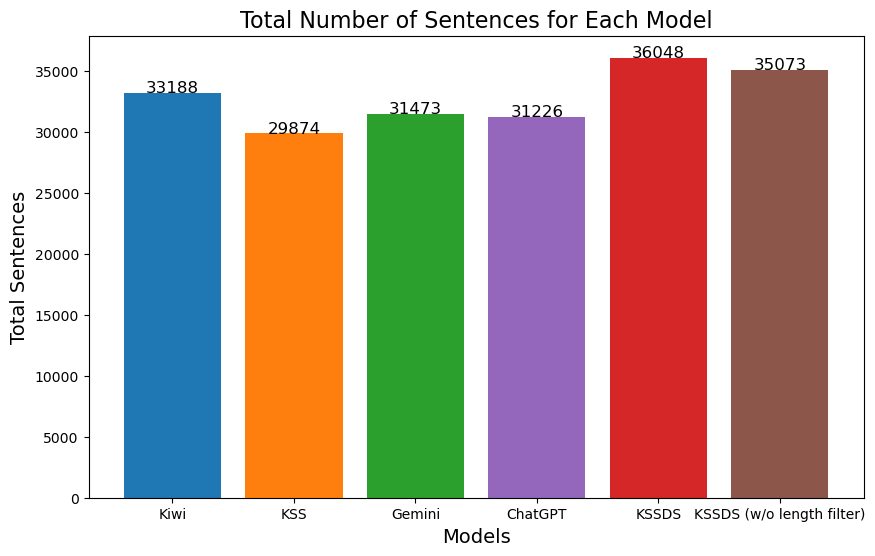

In [4]:
import matplotlib.pyplot as plt

# Plotting total sentences
models = ['Kiwi', 'KSS', 'Gemini', 'ChatGPT', 'KSSDS', 'KSSDS (w/o length filter)']
total_sentences = [total_sentences_kiwi, total_sentences_kss, total_sentences_gemini, total_sentences_chatgpt, total_sentences_ours, total_sentences_nolen]

plt.figure(figsize=(10, 6))
plt.bar(models, total_sentences, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728', '#8c564b'])
plt.title('Total Number of Sentences for Each Model', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Total Sentences', fontsize=14)

# Annotate the bars with the total sentence numbers
for i, v in enumerate(total_sentences):
    plt.text(i, v + 10, str(v), ha='center', fontsize=12)
plt.savefig("total_num_sent_validation", dpi=300, bbox_inches='tight')
plt.show()


In [5]:
import numpy as np

# Calculate mean and standard deviation for all models
kiwi_mean, kiwi_std = np.mean(kiwi_lengths), np.std(kiwi_lengths)
kss_mean, kss_std = np.mean(kss_lengths), np.std(kss_lengths)
gemini_mean, gemini_std = np.mean(gemini_lengths), np.std(gemini_lengths)
chatgpt_mean, chatgpt_std = np.mean(chatgpt_lengths), np.std(chatgpt_lengths)
ours_mean, ours_std = np.mean(ours_lengths), np.std(ours_lengths)
nolen_mean, nolen_std = np.mean(nolen_lengths), np.std(nolen_lengths)


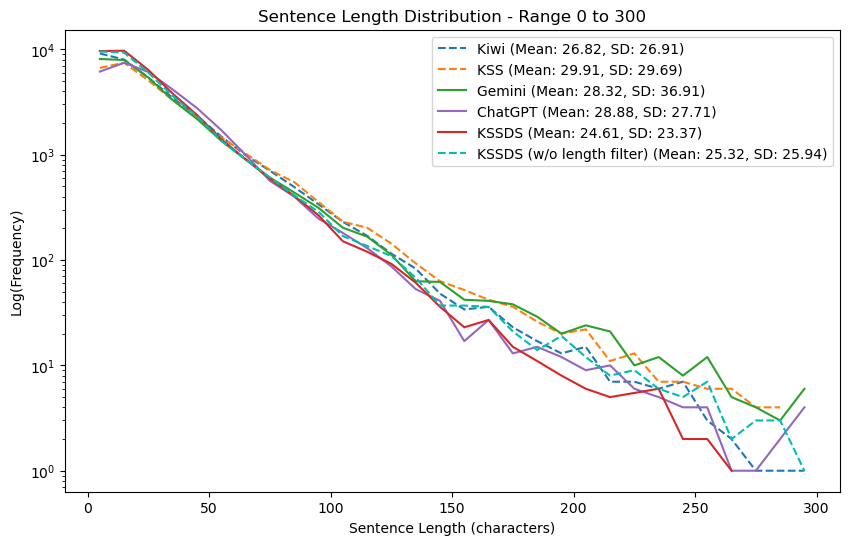

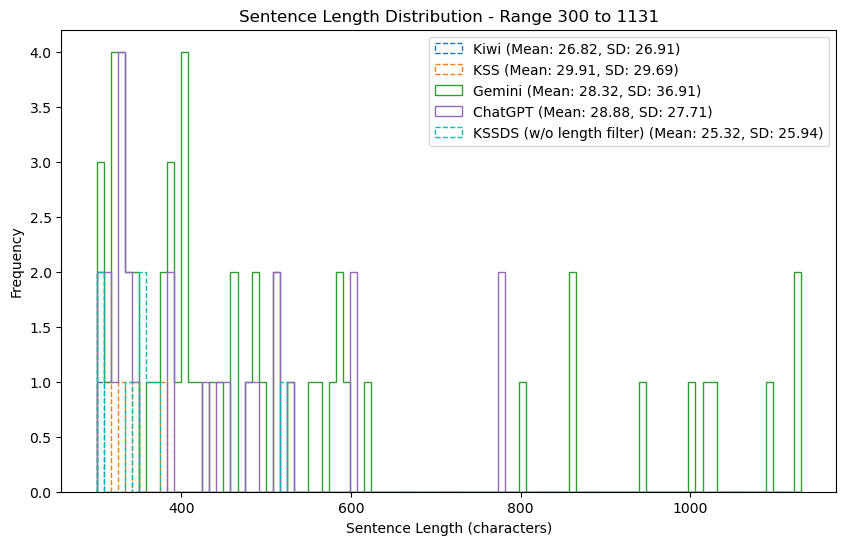

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dynamic_histogram(log_x=False, log_y=False, log_both=False, range_min=0, range_max=None, bins=100, use_smoothed=False):
    # Handle log scaling
    scale_x = 'log' if log_x or log_both else 'linear'
    scale_y = 'log' if log_y or log_both else 'linear'

    # Determine the range max if not specified
    if range_max is None:
        range_max = max(
            max(kss_lengths), max(gemini_lengths), max(chatgpt_lengths), 
            max(ours_lengths), max(kiwi_lengths), max(nolen_lengths)
        )

    # Define line styles and colors for distinguishability
    line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)), (0, (5, 10))]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728', '#00bfae']

    # Prepare the figure
    plt.figure(figsize=(10, 6))

    # Helper function to plot smoothed histograms
    def plot_smoothed_line(data, label, color, linestyle):
        hist, bin_edges = np.histogram(data, bins=bins, range=(range_min, range_max))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
        non_zero_indices = np.where(hist > 0)[0]
        if len(non_zero_indices) > 0:
            valid_bin_centers = bin_centers[non_zero_indices]
            valid_hist = hist[non_zero_indices]
            plt.plot(valid_bin_centers, valid_hist, linestyle=linestyle, label=label, color=color)

    # Helper function to plot step histograms
    def plot_step_histogram(data, label, color, linestyle):
        plt.hist(data, bins=bins, histtype='step', linestyle=linestyle, label=label, color=color, range=(range_min, range_max))

    # Choose plotting style based on `use_smoothed` flag
    plot_function = plot_smoothed_line if use_smoothed else plot_step_histogram

    # Plot each dataset dynamically
    plot_function(kiwi_lengths, f'Kiwi (Mean: {kiwi_mean:.2f}, SD: {kiwi_std:.2f})', colors[0], line_styles[1])
    plot_function(kss_lengths, f'KSS (Mean: {kss_mean:.2f}, SD: {kss_std:.2f})', colors[1], line_styles[1])
    plot_function(gemini_lengths, f'Gemini (Mean: {gemini_mean:.2f}, SD: {gemini_std:.2f})', colors[2], line_styles[0])
    plot_function(chatgpt_lengths, f'ChatGPT (Mean: {chatgpt_mean:.2f}, SD: {chatgpt_std:.2f})', colors[3], line_styles[0])
    if range_max <= 300 or max(ours_lengths) > 300:
        plot_function(ours_lengths, f'KSSDS (Mean: {ours_mean:.2f}, SD: {ours_std:.2f})', colors[4], line_styles[0])
    plot_function(nolen_lengths, f'KSSDS (w/o length filter) (Mean: {nolen_mean:.2f}, SD: {nolen_std:.2f})', colors[5], line_styles[1])

    # Set log scales if specified
    plt.xscale(scale_x)
    plt.yscale(scale_y)

    # Add labels and legend
    plt.title(f'Sentence Length Distribution - Range {range_min} to {range_max}')
    plt.xlabel('Sentence Length (characters)')
    plt.ylabel('Log(Frequency)' if scale_y == 'log' else 'Frequency')
    plt.legend(loc='upper right', fontsize=10)

    # Save and show the plot
    plot_type = "smoothed" if use_smoothed else "step"
    plt.savefig(f"dynamic_histogram_{plot_type}_{range_min}_{range_max}", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
# Smoothed histogram for range 0-300
plot_dynamic_histogram(log_y=True, range_min=0, range_max=300, bins=30, use_smoothed=True)

# Step histogram for range 300+
plot_dynamic_histogram(range_min=300, bins=100, use_smoothed=False)


In [30]:
# Prepare data with sentence lengths for each model
kiwi_data = [(file_path, len(sentence)) for file_path, data in kiwi_dict.items() for idx, sentence in data['sentences'].items()]
kss_data = [(file_path, len(sentence)) for file_path, data in kss_dict.items() for idx, sentence in data['sentences'].items()]
gemini_data = [(file_path, len(sentence)) for file_path, data in gemini_dict.items() for idx, sentence in data['sentences'].items()]
chatgpt_data = [(file_path, len(sentence)) for file_path, data in chatgpt_dict.items() for idx, sentence in data['sentences'].items()]
ours_data = [(file_path, len(sentence)) for file_path, data in kssds_dict.items() for idx, sentence in data['sentences'].items()]

# Skip NaN values in nolen_dict
nolen_data = [
    (file_path, len(sentence)) 
    for file_path, data in nolen_dict.items() 
    for idx, sentence in data['sentences'].items() 
    if isinstance(sentence, str) and sentence.strip()  # Skip NaN or blank sentences
]

# Sort by sentence length and get the top 15 longest sentences for each model
top_15_kiwi = sorted(kiwi_data, key=lambda x: x[1], reverse=True)[:15]
top_15_kss = sorted(kss_data, key=lambda x: x[1], reverse=True)[:15]
top_15_gemini = sorted(gemini_data, key=lambda x: x[1], reverse=True)[:15]
top_15_chatgpt = sorted(chatgpt_data, key=lambda x: x[1], reverse=True)[:15]
top_15_ours = sorted(ours_data, key=lambda x: x[1], reverse=True)[:15]
top_15_nolen = sorted(nolen_data, key=lambda x: x[1], reverse=True)[:15]

# Function to display the top 15 longest sentences for a given model
def display_top_15_sentences(model_name, top_15_data):
    print(f"\nTop 15 Longest Sentence Lengths for {model_name}:")
    for i, (file_path, length) in enumerate(top_15_data, start=1):
        base_name = os.path.basename(file_path)
        print(f"{i}. {base_name}: {length} characters")

# Display results for all models
display_top_15_sentences('Kiwi', top_15_kiwi)
display_top_15_sentences('KSS', top_15_kss)
display_top_15_sentences('Gemini', top_15_gemini)
display_top_15_sentences('ChatGPT', top_15_chatgpt)
display_top_15_sentences('KSSDS', top_15_ours)
display_top_15_sentences('KSSDS (w/o length filter)', top_15_nolen)



Top 15 Longest Sentence Lengths for Kiwi:
1. 2_0028G1A3_0023G1A2_T1_2D10T0421C000805_000494.wav: 305 characters
2. 2_0022G2A4_0024G2A4_T1_2D08T0358C001242_000404.wav: 291 characters
3. 2_0087G1A3_0086G1A2_T1_2D04T0155C000318_000651.wav: 288 characters
4. 2_0580G2A5_0579G2A4_T1_2D02T0099C000714_001982.wav: 275 characters
5. 2_0028G1A3_0023G1A2_T1_2D10T0421C000805_000494.wav: 268 characters
6. 2_0637G2A3_0638G2A3_T1_2D08T0341C000335_002139.wav: 266 characters
7. 2_0642G2A3_0641G1A3_T1_2D09T0403C000339_006104.wav: 256 characters
8. 2_0275G2A5_0278G2A5_T1_2D10T0440C000281_001165.wav: 252 characters
9. 2_0658G2A4_0657G2A4_T1_2D05T0209C000330_002950.wav: 250 characters
10. 2_0637G2A3_0638G2A3_T1_2D08T0341C000335_002139.wav: 249 characters
11. 2_0473G2A4_0474G2A3_T1_2D09T0400C000520_001718.wav: 248 characters
12. 2_0650G2A5_0649G2A4_T1_2D08T0341C000376_002192.wav: 247 characters
13. 2_0027G1A2_0026G1A2_T1_2D01T0048C000322_000551.wav: 242 characters
14. 2_0248G2A2_0247G2A5_T1_2D02T0063C000914

In [31]:
# Dictionary that maps model names to their corresponding data dictionaries
model_dicts = {
    'Kiwi': kiwi_dict,
    'KSS' : kss_dict,
    'Gemini': gemini_dict,
    'ChatGPT': chatgpt_dict,
    'KSSDS': kssds_dict,
    'KSSDS (w/o length filter)': nolen_dict
}

# Function to display sentences for a specific file path from "Ours" and a specified model
def display_sentences_for_file(file_path, compare_model):
    # Extract the base name from the file path
    base_file_name = os.path.basename(file_path)
    
    # Initialize variable to store the matched file paths
    ours_file_path = None
    compare_file_path = None

    # Check if the base name exists in Ours dictionary
    for key in kssds_dict.keys():
        if os.path.basename(key) == base_file_name:
            ours_file_path = key
            break

    # Check if the base name exists in the compare_model dictionary
    model_dict = model_dicts.get(compare_model)
    if model_dict:
        for key in model_dict.keys():
            if os.path.basename(key) == base_file_name:
                compare_file_path = key
                break

    # Validate file paths
    if not ours_file_path:
        print(f"File Path '{base_file_name}' not found in 'KSSDS' data.")
        return
    
    if not compare_file_path:
        print(f"File Path '{base_file_name}' not found in '{compare_model}' data.")
        return

    # Adjust pandas options to display all rows and columns without truncation
    pd.set_option('display.max_rows', None)  # Show all rows
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.max_colwidth', None)  # Show full width of each column
    pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

    # Get sentences for the provided file path from Ours and the comparison model
    ours_sentences = kssds_dict[ours_file_path]['sentences']
    compare_model_sentences = model_dict[compare_file_path]['sentences']

    # Create a DataFrame by merging the sentences based on their Index
    merged_df = pd.DataFrame({
        'Index': sorted(set(ours_sentences.keys()).union(compare_model_sentences.keys())),
        'Ours Transcription': [ours_sentences.get(idx, '') for idx in sorted(set(ours_sentences.keys()).union(compare_model_sentences.keys()))],
        f'{compare_model} Transcription': [compare_model_sentences.get(idx, '') for idx in sorted(set(ours_sentences.keys()).union(compare_model_sentences.keys()))]
    })

    # Apply styling to hide index and set custom column widths
    styled_df = merged_df.style.set_table_attributes('style="width: auto;"') \
        .set_table_styles({
            'Ours Transcription': [{'selector': 'td', 'props': [('max-width', '450px'), ('overflow', 'hidden'), ('text-overflow', 'ellipsis'), ('white-space', 'normal'), ('text-align', 'left')]}],
            f'{compare_model} Transcription': [{'selector': 'td', 'props': [('max-width', '450px'), ('overflow', 'hidden'), ('text-overflow', 'ellipsis'), ('white-space', 'normal'), ('text-align', 'left')]}],
            'Index': [{'selector': 'td', 'props': [('width', '50px'), ('text-align', 'center')]}]  # Center align Index column
        }) \
        .hide(axis="index")  # Hide the DataFrame index

    # Display the styled DataFrame
    display(styled_df)


In [32]:
# Dictionary that maps model names to their corresponding data dictionaries
model_dicts = {
    'Kiwi': kiwi_dict,
    'KSS': kss_dict,
    'Gemini': gemini_dict,
    'ChatGPT': chatgpt_dict,
    'KSSDS': kssds_dict,
    'KSSDS (w/o length filter)': nolen_dict
}

# Function to display the longest sentence and its length for each model for a specific file
import pandas as pd

def display_longest_sentences_and_lengths(file_path):
    # Extract the base name from the file path
    base_file_name = os.path.basename(file_path)

    # Initialize dictionary to store the longest sentences and their lengths from each model
    longest_sentences = {}
    longest_lengths = {}

    # Loop through each model and find the longest sentence for the given file
    for model_name, model_dict in model_dicts.items():
        # Check if the file exists in the model's dictionary
        model_file_path = None
        for key in model_dict.keys():
            if os.path.basename(key) == base_file_name:
                model_file_path = key
                break

        if model_file_path:
            # Find the longest sentence and its length for the given file
            sentences = model_dict[model_file_path]['sentences']
            longest_sentence = max(sentences.values(), key=len, default="")
            longest_sentences[model_name] = longest_sentence
            longest_lengths[model_name] = len(longest_sentence)
        else:
            longest_sentences[model_name] = "File not found in model's data"
            longest_lengths[model_name] = 0

    # Convert the results into a DataFrame for better display
    result_df = pd.DataFrame(
        {
            "Model": list(longest_sentences.keys()),
            "Longest Sentence": list(longest_sentences.values()),
            "Length of Longest Sentence": list(longest_lengths.values())
        }
    )

    # Adjust pandas options to display all rows and columns without truncation
    pd.set_option('display.max_rows', None)  # Show all rows
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.max_colwidth', None)  # Show full width of each column

    # Display the DataFrame
    display(result_df)


# KSS 모델이 제일 못자른 파일

In [35]:
display_longest_sentences_and_lengths("2_0642G2A3_0641G1A3_T1_2D09T0403C000339_006104.wav")

,Model,Longest Sentence,Length of Longest Sentence
0,Kiwi,그치 그래서 아무래도 날씨가 선선한 봄 가을에 사람들이 캠핑을 많이 다니는 것 같은데 여름 보다는 어 그래 응 겨울은 너무 춥고 사실 진짜 제대로 된 낭만이나 이런 건 겨울이라고는 하는데 음 힘들다는 걸 돌려 하라는 거 아무튼 뭐 일단은 딱 봐도 추우니까 짐도 엄청 많아야 되고 많이 챙겨야 되고 맞아 여름 같은 경우는 숙박시설 이런 거 잘 찾고 하면 수영장을 또 이용할 수 있으니까 물론 뭐 저 계곡에서 노는 것도 좋긴 한데 계곡에서 노는 거 좋은 거 같아,256
1,KSS,근데 발 담그고 하면 땀을 흘릴 일이 별로 없지 않나 물이 엄청 차가우니까 계곡 물은 아니 위에는 땀을 삐질삐질 흘리면서 달만 시원하다고 생각할 것 같은데 전혀 난 체온이 전체적으로 떨어지면서 그렇게 생각해서 아무튼 캠핑은 그치 산 있는데 경치 좋고 공기 좋은데 그런 데다가 딱 텐트 치고 타프 치고 의자 한 두개 세팅하고 그럼 저기 장작 같은 거 이렇게 화로뿔리고 딱 해놓고 마시멜로 구워 먹고 고구마 감자 호일에 싸서 넣고 옥수수 구워 먹고 맛있겠다 맞아 맞아 생선 같은 것도 구워 먹고 싶은데 생선 난 곱창 미국식인가 꽃이 딱 껴 가지고 아 그건 영화식 영화식 서부 영화 미드식 미드식 미드식 레데리 같은 거 어 레데리 맞아 그리고 이제 스튜 같은 거 올리고 응 스튜 스팅?,380
2,Gemini,난 또 어렸을 때 텐트 치고 이렇게 다니긴 했는데 바닷가 그러니까 생각나는 거는 저기 망상해수욕장에 거기 강원도 쪽이거든 군인 가족들을 위한 군인 막사 같은 게 이렇게 지어 놓은 거 있어 가지고 그거 빌려서 막 놀고 이랬었는데 어렸을 때는 음 군인 막사를 빌려서 가족들을 위해서 군인 막사 같은 걸 따로 쳐놨더라고 안에서 이렇게 쉬고 놀고 자고 할 수 있게 되게 좋았었지,207
3,ChatGPT,그러니까 이 덤과 이 벌레와 모든 걸 내가 다 끌어안겠다 이 냄새와 이런 것들을 내가 다 안고 하겠다 이런 마음가짐을 딱 장착하고 가면은 견딜 수 있을 것 같은데.,91
4,KSSDS,텐트 치고 막 세팅하고 치우고 이런 거에 귀찮음을 힐링이 이길 수 있을 때 정말 귀찮은데 힐링하는 게 더 크다 이러면 가는 계속 가 다니는데 귀찮음이 더 크다 이러면 못 가는 거래,100
5,KSSDS (w/o length filter),물이 엄청 차가우니까 계곡 물은 아니 위에는 땀을 삐질삐질 흘리면서 달만 시원하다고 생각할 것 같은데 전혀 난 체온이 전체적으로 떨어지면서 그렇게 생각해서 아무튼 캠핑은 그치 산 있는데 경치 좋고 공기 좋은데 그런 데다가 딱 텐트 치고 타프 치고 의자 한 두개 세팅하고 그럼 저기 장작 같은 거 이렇게 화로뿔리고 딱 해놓고 마시멜로 구워 먹고 고구마 감자 호일에 싸서 넣고 옥수수 구워 먹고 맛있겠다,223


# Kiwi 모델이 제일 못자른 파일

In [36]:
display_longest_sentences_and_lengths("2_0028G1A3_0023G1A2_T1_2D10T0421C000805_000494.wav")

,Model,Longest Sentence,Length of Longest Sentence
0,Kiwi,"저는 피곤은 피곤들을 쌓인 상태에서 왜 굳이 이거를 누가 정한 시간인지 알 수 없지만 6시까지 가서 아침 7시에 밥을 먹고 저는 평소에도 7시에 밥을 먹지 않는데 그 애기들 뭐 운우는 애들 다 데리고 가서 해야 되는데 이걸 매번 해야 되는데 사실 설날과 한가위라고 불리는 명절이 정말 없을 때, 먹기 힘들었을 때 이제 추수의 기쁨을 함께 누리고 함께 뒷대만으로 배부르게 먹자 라고 시작된 걸로 알고 있는데 이렇게 하는 걸로 알고 있는데 사실 저희가 김진수 님의 생활이 얼마나 힘든지, 얼마나 풍요로운지 알 수 없지만 먹는 것 때문에 고민 없잖아요",305
1,KSS,"저는 피곤은 피곤들을 쌓인 상태에서 왜 굳이 이거를 누가 정한 시간인지 알 수 없지만 6시까지 가서 아침 7시에 밥을 먹고 저는 평소에도 7시에 밥을 먹지 않는데 그 애기들 뭐 운우는 애들 다 데리고 가서 해야 되는데 이걸 매번 해야 되는데 사실 설날과 한가위라고 불리는 명절이 정말 없을 때, 먹기 힘들었을 때 이제 추수의 기쁨을 함께 누리고 함께 뒷대만으로 배부르게 먹자 라고 시작된 걸로 알고 있는데 이렇게 하는 걸로 알고 있는데 사실 저희가 김진수 님의 생활이 얼마나 힘든지, 얼마나 풍요로운지 알 수 없지만 먹는 것 때문에 고민 없잖아요",305
2,Gemini,"네 거기다 제사통에다 올리는 4,50만원 올린 것보다 차라리 부모님 TV 한 대에다 드리는 게 더 낫다고 생각하고 그니까요 평소에 굳이 그걸 정해서 하는 것보다 평소에 방금 말씀하신 것처럼 시간 날 때 한번 얼굴 뵙고 찾아가고 이런 게 더 낫다고 생각해요 진짜 네 막 국가적으로 정해져 있으니까 모두가 한 번에 움직이니까 너무 비용 시간이 너무 많이 들어서 와 진짜 그냥 각자 각자 편할 때 가는 게 좋은 거 같아요 아니 왜 굳이 그날 가야 되는 거야 저희는 저는 그 애기들 고속도로에서 다섯 시간 있잖아요 애기들 소리 지르고 난리 나요 하하 애기들 소리 지르고 난리 나고 진짜 중간에 똥 마렵다 어 저속도로에서 갑자기 갓길에 태우고 쉿사고 있고 막 얼마 있는데 왜 굳이 그때를 정해서 이렇게 해야 되는 건가 물론 이제 그런 역사적인 역사적인 하는 게 맞는지 아니면 역사적인지 전통인지 정통인지에 대해서는 좀 잘 모르겠지만 계속해서 쉐일로 지정하는 거에 대해서는 큰 의견이 없지만 이런 것까지는 좀 더 많이 변화될 필요가 있을 것 같아요 저는 그리고 확실히 아직도 되게 심하게 지키는 집회도 있잖아요 너무 답답해요 저는 진짜 제사도 막 한복 입고 난리 치고 할 거 다 하잖아요 저는 진짜 그 격식이 뭐라고 이렇게 지키는 거 보면 마음이 답답하네요 솔직히 저는 제가 아니니까 뭐라 말 못하겠지만 당사자가 또 아니니까 저도 다 말할 수 없지만 좀 답답하네요 솔직히 네 제 친구네 집이 약간 가문 이런 걸 되게 해서 막 진짜 무슨 몇 대 손 그걸 다 해요 제사를 몇 대 위에 분 그걸 다 하는데 걔도 진짜 너무 싫어하고 근데 또 그런 거 하면 약간 그런 것도 그래요 준비는 어머니들이 다 하시는데 약간 또 그 기분 챙기기는 또 아버지들이 하시는 게 또 있기도 하잖아요 그런 집도 있잖아요 뭔가 내가 효도는 내가 하고 있다 약간 그런 준비는 어머님들이 막 열심히 요리 하셨지만 아 효도 내가 하고 있다 그런 것도 볼 때 아 이게 진짜 문제는 문제다 저희 집도 이제 제사하고 이러면 저희 아버지는 둘째세요 그래서 큰아버지가 또 계신데 항상 그렇게 딱 보면은 모든 집이 그런지는 모르겠지만 첫째 분들이 확실히 되게 더 따지시기는 해요 막 이거 해야 되고 저거 해야 되고 큰아버지가 되게 따지시는데 막상 그렇게 또 움직이진 않으세요.",1131
3,ChatGPT,사실 따지면 양반 노비 천민 출신들이 저도 아마 그렇겠죠 당연히 솔직히 말해서 저도 그렇겠죠 정말 많을 텐데 정말 이제 와서는 솔직히 말하면 지금 현재 직업이 전부인 세상에서 백날 그 윤석열은 솔직히 말해서 지금 윤석열 대통령 노비 출신이면 뭐 할 거야 지금 대통령인데 지금 현재 직업이 중요한 거 아닌가 백날 양반이었으면 뭐 해 지금 앞에서 저기 앞에서 수저 긁고 있으면 뭐 할 거야 아무 의미 없는 진짜 가문 따지는 진짜 저는 솔직히 더 이상 안 했으면 좋겠고 이게 진짜 어려운 거는 이제 위에 세대 분들이 원하시니까 그런 거 같아요 맞아요 맞아요 저도 솔직히 말해서 저희 아버지가 그렇게 원하세요 저는 저희 집이 얼마나 대단했는지 모르겠지만 항상 그 얘기를 하세요 저희 집이 북한에서 6.25 때 할머니가 내려오셨거든요 근데 정말 잘 살았대요 제가 생각해도 잘 산 거 맞는 것 같아요 왜냐면 내려올 때 저희 식기구가 다 은 젓가락 은 숟가락 그리고 식기구 다 은이었어요 저희 집은 그래서 어렸을 때 은 숟가락 쓰고 지났는데 그러면 뭐해? 지금 물려받은 게 없는데 얼마나 대단한 집안인지는 모르겠어요 근데 이제 아마 굉장히 제가 많이 듣기로도 굉장히 성공하시고 근데 솔직히 말해서 노비 출신이었는데 성공한 건지 원래부터 양반이었는지는 사실 알 수 없잖아요 그게 중요한 게 아니에요 솔직히 저는 제 생각에는 그 이상 중요한 게 아니고 앞으로의 지금 현재와 미래가 중요하지 언제까지 그 양반 천민 여기 노비 살평 얼매여가지고 계속해서 안주거리 삼아서 얘기할 것인가 저는 그렇게 생각해요.,776
4,KSSDS,먹기 싫어서 안 사놓고 먹기 싫어서 안 먹으니까 안 사놓고 먹기 싫어서 안 먹는 것 뿐인데 이제 이것들을 강제로 이제 그런 의미가 굉장히 폐색된 상태에서 와서 또 이제 꾸역꾸역 먹어야 되는게 정말 시간적 낭비와 긍정적 낭비 그리고 이제 신체적으로도 학대를 한다고 생각하는데 저는 이게 더 이상 불필요하다고 생각을 하거든요,179
5,KSSDS (w/o length filter),"저는 피곤은 피곤들을 쌓인 상태에서 왜 굳이 이거를 누가 정한 시간인지 알 수 없지만 6시까지 가서 아침 7시에 밥을 먹고 저는 평소에도 7시에 밥을 먹지 않는데 그 애기들 뭐 운우는 애들 다 데리고 가서 해야 되는데 이걸 매번 해야 되는데 사실 설날과 한가위라고 불리는 명절이 정말 없을 때, 먹기 힘들었을 때 이제 추수의 기쁨을 함께 누리고 함께 뒷대만으로 배부르게 먹자 라고 시작된 걸로 알고 있는데 이렇게 하는 걸로 알고 있는데 사실 저희가 김진수 님의 생활이 얼마나 힘든지, 얼마나 풍요로운지 알 수 없지만 먹는 것 때문에 고민 없잖아요",305


# ChatGPT 모델이 제일 못자른 파일

In [38]:
display_longest_sentences_and_lengths("2_0185G2A4_0184G2A4_T1_2D05T0179C000140_000920.wav")

,Model,Longest Sentence,Length of Longest Sentence
0,Kiwi,머리 개수가 늘어나진 않더라도 조금만 모발이 굵어지고 탄력이 있어도 양을 줘도 도움이 되는 거지 만약에 더 빠지는 게 나아진다거나 아니면 조금만 굵어져도 전체적으로 조금 더 평상해 보이지 않겠나 맞지?,112
1,KSS,그런 거 지나가다 보면 빨리 가는 게 좋다더라고 그러니까 빨리 치료받으면 조금이라도 있잖아 머리 개수가 늘어나진 않더라도 조금만 모발이 굵어지고 탄력이 있어도 양을 줘도 도움이 되는 거지 만약에 더 빠지는 게 나아진다거나 아니면 조금만 굵어져도 전체적으로 조금 더 평상해 보이지 않겠나 맞지?,163
2,Gemini,그러니까 저렇게 까진 안 돼도 있잖아 어느 정도면 우리 지금보다 지금보다 조금이라도 더 그 막 부름 난 그래서 피부과에 한번 가보려고 하는 게 지금 연장에 누가 아하 지금 너무 세우고 싶어 하냐 라고 말하더라고,117
3,ChatGPT,아니 고소영이 방금 나왔던 티비에 그 명기 영양제 선전을 했는데 광고를 했는데 머리 숱이 풍성하네 그래서 우리가 원하는 딱 그런 헤어스타일을 하고 있는데 머리 숱이 풍성하니까 너무 예쁘네 진짜 어 아니 그니까 얼굴을 떠나서 말이야 얼굴을 응 근데 왜 이렇게 안 나오지 맞아 맞아 어 그러면 이쁘지 그니까 왜 그니까 다른데가 좀 그래도 그니까 그렇게 이쁜 얼굴 아니라도 피부 하나 좋아도 또 빛이 나잖아 맞지 그니까 아무리 좀 얼굴이 조금은 안 돼도 있잖아 머리숱이 있잖아 많잖아 그러면 이쁜 머리를 하고 나오잖아 그러면 엄청 이뻐 보인다 응 어 그리고 얼마나 관리하겠노 뭐 두피 관리 맞아 맞아 맞아 응 그거 진짜 무시 못하는 거다 그렇지 근데 정말 관리해서 그래 저정도를 잘 유지하고 있겠지만 차이가 없잖아 응 그러니까 저렇게 까진 안 돼도 있잖아 어느 정도면 우리 지금보다 지금보다 조금이라도 더 그 막 부름 난 그래서 피부과에 한번 가보려고 하는 게 지금 연장에 누가 아하 지금 너무 세우고 싶어 하냐 라고 말하더라고 피부 마사지도 할 거고 진짜 관리 많이 할 것 같아요 여자들은 바르는 거 준다대 어 그러더라 처음부터 머리에 처음에 머리 주사 줄까 봐 안 갔는데 처음에 바르는 거 준다고 들은 것 같아 그러면 바르는 거 일단은 발라보고 모분이 튼튼하게 돼서 모발이 굵어질 수도 있잖아 여자들은 몰라요 전문의들 나오고 탈모 때문에 고민이 있는 사람들께 얘기하잖아 그 남은 거 이제 한 번씩 TV에 보면 아침마다 같은 데 한 번씩 하대 그런 거 지나가다 보면 빨리 가는 게 좋다더라고.,777
4,KSSDS,그래 그 사람들은 이제 또 머리숱 많은 사람들은 또 머리숱 많아가지고 너무 많다 이렇게 할 수가 있는데 자기는 또 그 나름대로 고민이 있을 수 있는데 진짜 나중에 이제 나이가 들면 아 네 진짜 너무 힘들어.,115
5,KSSDS (w/o length filter),그래 그 사람들은 이제 또 머리숱 많은 사람들은 또 머리숱 많아가지고 너무 많다 이렇게 할 수가 있는데 자기는 또 그 나름대로 고민이 있을 수 있는데 진짜 나중에 이제 나이가 들면 아 네 진짜 너무 힘들어.,115


# Gemini 모델이 제일 못자른 파일

In [37]:
display_longest_sentences_and_lengths("2_0028G1A3_0023G1A2_T1_2D10T0421C000805_000494.wav")

,Model,Longest Sentence,Length of Longest Sentence
0,Kiwi,"저는 피곤은 피곤들을 쌓인 상태에서 왜 굳이 이거를 누가 정한 시간인지 알 수 없지만 6시까지 가서 아침 7시에 밥을 먹고 저는 평소에도 7시에 밥을 먹지 않는데 그 애기들 뭐 운우는 애들 다 데리고 가서 해야 되는데 이걸 매번 해야 되는데 사실 설날과 한가위라고 불리는 명절이 정말 없을 때, 먹기 힘들었을 때 이제 추수의 기쁨을 함께 누리고 함께 뒷대만으로 배부르게 먹자 라고 시작된 걸로 알고 있는데 이렇게 하는 걸로 알고 있는데 사실 저희가 김진수 님의 생활이 얼마나 힘든지, 얼마나 풍요로운지 알 수 없지만 먹는 것 때문에 고민 없잖아요",305
1,KSS,"저는 피곤은 피곤들을 쌓인 상태에서 왜 굳이 이거를 누가 정한 시간인지 알 수 없지만 6시까지 가서 아침 7시에 밥을 먹고 저는 평소에도 7시에 밥을 먹지 않는데 그 애기들 뭐 운우는 애들 다 데리고 가서 해야 되는데 이걸 매번 해야 되는데 사실 설날과 한가위라고 불리는 명절이 정말 없을 때, 먹기 힘들었을 때 이제 추수의 기쁨을 함께 누리고 함께 뒷대만으로 배부르게 먹자 라고 시작된 걸로 알고 있는데 이렇게 하는 걸로 알고 있는데 사실 저희가 김진수 님의 생활이 얼마나 힘든지, 얼마나 풍요로운지 알 수 없지만 먹는 것 때문에 고민 없잖아요",305
2,Gemini,"네 거기다 제사통에다 올리는 4,50만원 올린 것보다 차라리 부모님 TV 한 대에다 드리는 게 더 낫다고 생각하고 그니까요 평소에 굳이 그걸 정해서 하는 것보다 평소에 방금 말씀하신 것처럼 시간 날 때 한번 얼굴 뵙고 찾아가고 이런 게 더 낫다고 생각해요 진짜 네 막 국가적으로 정해져 있으니까 모두가 한 번에 움직이니까 너무 비용 시간이 너무 많이 들어서 와 진짜 그냥 각자 각자 편할 때 가는 게 좋은 거 같아요 아니 왜 굳이 그날 가야 되는 거야 저희는 저는 그 애기들 고속도로에서 다섯 시간 있잖아요 애기들 소리 지르고 난리 나요 하하 애기들 소리 지르고 난리 나고 진짜 중간에 똥 마렵다 어 저속도로에서 갑자기 갓길에 태우고 쉿사고 있고 막 얼마 있는데 왜 굳이 그때를 정해서 이렇게 해야 되는 건가 물론 이제 그런 역사적인 역사적인 하는 게 맞는지 아니면 역사적인지 전통인지 정통인지에 대해서는 좀 잘 모르겠지만 계속해서 쉐일로 지정하는 거에 대해서는 큰 의견이 없지만 이런 것까지는 좀 더 많이 변화될 필요가 있을 것 같아요 저는 그리고 확실히 아직도 되게 심하게 지키는 집회도 있잖아요 너무 답답해요 저는 진짜 제사도 막 한복 입고 난리 치고 할 거 다 하잖아요 저는 진짜 그 격식이 뭐라고 이렇게 지키는 거 보면 마음이 답답하네요 솔직히 저는 제가 아니니까 뭐라 말 못하겠지만 당사자가 또 아니니까 저도 다 말할 수 없지만 좀 답답하네요 솔직히 네 제 친구네 집이 약간 가문 이런 걸 되게 해서 막 진짜 무슨 몇 대 손 그걸 다 해요 제사를 몇 대 위에 분 그걸 다 하는데 걔도 진짜 너무 싫어하고 근데 또 그런 거 하면 약간 그런 것도 그래요 준비는 어머니들이 다 하시는데 약간 또 그 기분 챙기기는 또 아버지들이 하시는 게 또 있기도 하잖아요 그런 집도 있잖아요 뭔가 내가 효도는 내가 하고 있다 약간 그런 준비는 어머님들이 막 열심히 요리 하셨지만 아 효도 내가 하고 있다 그런 것도 볼 때 아 이게 진짜 문제는 문제다 저희 집도 이제 제사하고 이러면 저희 아버지는 둘째세요 그래서 큰아버지가 또 계신데 항상 그렇게 딱 보면은 모든 집이 그런지는 모르겠지만 첫째 분들이 확실히 되게 더 따지시기는 해요 막 이거 해야 되고 저거 해야 되고 큰아버지가 되게 따지시는데 막상 그렇게 또 움직이진 않으세요.",1131
3,ChatGPT,사실 따지면 양반 노비 천민 출신들이 저도 아마 그렇겠죠 당연히 솔직히 말해서 저도 그렇겠죠 정말 많을 텐데 정말 이제 와서는 솔직히 말하면 지금 현재 직업이 전부인 세상에서 백날 그 윤석열은 솔직히 말해서 지금 윤석열 대통령 노비 출신이면 뭐 할 거야 지금 대통령인데 지금 현재 직업이 중요한 거 아닌가 백날 양반이었으면 뭐 해 지금 앞에서 저기 앞에서 수저 긁고 있으면 뭐 할 거야 아무 의미 없는 진짜 가문 따지는 진짜 저는 솔직히 더 이상 안 했으면 좋겠고 이게 진짜 어려운 거는 이제 위에 세대 분들이 원하시니까 그런 거 같아요 맞아요 맞아요 저도 솔직히 말해서 저희 아버지가 그렇게 원하세요 저는 저희 집이 얼마나 대단했는지 모르겠지만 항상 그 얘기를 하세요 저희 집이 북한에서 6.25 때 할머니가 내려오셨거든요 근데 정말 잘 살았대요 제가 생각해도 잘 산 거 맞는 것 같아요 왜냐면 내려올 때 저희 식기구가 다 은 젓가락 은 숟가락 그리고 식기구 다 은이었어요 저희 집은 그래서 어렸을 때 은 숟가락 쓰고 지났는데 그러면 뭐해? 지금 물려받은 게 없는데 얼마나 대단한 집안인지는 모르겠어요 근데 이제 아마 굉장히 제가 많이 듣기로도 굉장히 성공하시고 근데 솔직히 말해서 노비 출신이었는데 성공한 건지 원래부터 양반이었는지는 사실 알 수 없잖아요 그게 중요한 게 아니에요 솔직히 저는 제 생각에는 그 이상 중요한 게 아니고 앞으로의 지금 현재와 미래가 중요하지 언제까지 그 양반 천민 여기 노비 살평 얼매여가지고 계속해서 안주거리 삼아서 얘기할 것인가 저는 그렇게 생각해요.,776
4,KSSDS,먹기 싫어서 안 사놓고 먹기 싫어서 안 먹으니까 안 사놓고 먹기 싫어서 안 먹는 것 뿐인데 이제 이것들을 강제로 이제 그런 의미가 굉장히 폐색된 상태에서 와서 또 이제 꾸역꾸역 먹어야 되는게 정말 시간적 낭비와 긍정적 낭비 그리고 이제 신체적으로도 학대를 한다고 생각하는데 저는 이게 더 이상 불필요하다고 생각을 하거든요,179
5,KSSDS (w/o length filter),"저는 피곤은 피곤들을 쌓인 상태에서 왜 굳이 이거를 누가 정한 시간인지 알 수 없지만 6시까지 가서 아침 7시에 밥을 먹고 저는 평소에도 7시에 밥을 먹지 않는데 그 애기들 뭐 운우는 애들 다 데리고 가서 해야 되는데 이걸 매번 해야 되는데 사실 설날과 한가위라고 불리는 명절이 정말 없을 때, 먹기 힘들었을 때 이제 추수의 기쁨을 함께 누리고 함께 뒷대만으로 배부르게 먹자 라고 시작된 걸로 알고 있는데 이렇게 하는 걸로 알고 있는데 사실 저희가 김진수 님의 생활이 얼마나 힘든지, 얼마나 풍요로운지 알 수 없지만 먹는 것 때문에 고민 없잖아요",305


# KSSDS without Length Filter 모델이 제일 못자른 파일

In [33]:
display_longest_sentences_and_lengths("2_0471G2A4_0448G2A6_T1_2D02T0097C000880_001713.wav")

,Model,Longest Sentence,Length of Longest Sentence
0,Kiwi,그래 요새 그 누구 그 또 일용이 엄마 아 김수미가 김수미 김수미 아아 김수민 뭐 하는데 나 모르는데 음식 만들어 갖고 음식 그것도 하고 홈쇼핑 같은데 그사람 요리 솜씨가 좋아 갖고 요리를 잘하더라 요리 솜씨가 좋아 갖고 한동안 나아 갖고 지금도 그래 뭐 무슨 갈비 무슨 이런거 하마 와우 그래 뭐 이 사람이 참을 만들면은 넘을 주는 거를 좋아하는 거라 할라 뭔가,203
1,KSS,뭐 담으면 누구누구만 아마 누구 저거 그거 항신에 이런 거는 언니 언니 하고 나이 많은 선배님인데도 언니 언니 하고 얼마나 따로 했는갑대 텔레비전 나갈거래서 대그래 그러고 아니 우리도 몰랐어 되게 막 욕 잘하고 드실 줄 알았는데 그런 인정이 어 어 그러니까 막 말은 걸걸하게 하고 인상을 좀 구례 보여도 마음은 따뜻한 사람이었나 보지 따뜻한 사람인거라 뭘 하면은 여러 사람들하고 조금 없는 그런 사람들도 갈라줄 줄 알고 응응 응 또 뭐 뭐 하면 퍼다 죽고 있나,257
2,Gemini,되게 막 욕 잘하고 드실 줄 알았는데 그런 인정이 어 어 그러니까 막 말은 걸걸하게 하고 인상을 좀 구례 보여도 마음은 따뜻한 사람이었나 보지 따뜻한 사람인거라 뭘 하면은 여러 사람들하고 조금 없는 그런 사람들도 갈라줄 줄 알고 응응 응,132
3,ChatGPT,그래 요새 그 누구 그 또 일용이 엄마 아 김수미가 김수미 김수미 아아 김수민 뭐 하는데 나 모르는데 음식 만들어 갖고 음식 그것도 하고 홈쇼핑 같은데.,85
4,KSSDS,아니 그래 난 다른 건 모르겠는데 뭐 눈 뭐 생긴 건 모르겠는데 머리가 큰 거는 이제 알고 있었는데 자기 며느리하고 자기 아들 얘기하는데 있잖아 우린 누가 봐도 누가 봐도 그 며느리가 나은 것 같은데 유명세도 그렇고 인기도 그렇고 아들은 별 볼일 없었죠 아들은 별 볼일 없는데 아무 별 볼일 없잖아 여자는 그래도 좀 있을 수 있어도 근데 자기한테는 아들이 최고인지 있잖아.,208
5,KSSDS (w/o length filter),그래 연예인이면 싫지 그래 지 바쁘고 요새 그런 세상에 뭐 전부 다 뭐 지 그 일을 챙기고 하는데 응응 그래 나 그거 보면 그런 것도 잘하고 텔레비전도 그래도 역할도 잘하고 연기도 잘하고 옛날에 그 전음일기 일기 그거 할 때 그 뿐만 아니고 뭐 선유타리는 잘한다 그래 일용없니 너무 맞제 욕도 잘하고 딱 그 뭐 시골 할머니 딱이었는데 근데 그때 그 뭐야 김수미 나이가 엄청 젊었다 하더라 어 20대 후반인데 그 일용이 어 그렇게 잘하고 와있나 말하던 목소리 봐야 목소리 다 그 뭐란게 타고난 그래가지고 그때부터 뭐해가 전원유가 뭐 십년 했노 최장수 프로 아이가 나는 모르는데 그래 요새 뭐 또 재방송이 한다대 재방송이 하는데 나는 뭐 그런거 뭐 따분해서 그거 안 틀거든 옛날에 우리도 뭐 전원유기 다 봤는데고 뭐 할게고 남성 이모는 야 지금 전원유기 하는 회사거든 나는 그 따분하게 좀 그 말을 볼게고 경하신랑은 그거를 완전 재밌게 본다는 거야 지금도 재방송은 그래 우리가 있잖아 와 그런 것도 보구나 싶었지 우리는 어릴 때 뭐 지나다가,524


# KSSDS 모델이 제일 못자른 파일

In [39]:
display_longest_sentences_and_lengths("2_0637G2A3_0638G2A3_T1_2D08T0341C000335_002139.wav")

,Model,Longest Sentence,Length of Longest Sentence
0,Kiwi,"지금은 운동 허리 근육 강화되는 고양이 자세 그걸 굉장히 많이 주변에서 얘기를 하고 운동 재활치료 선생님도 그게 좋다고 하는데 그거를 하긴 하지만 결국 큰 효과는 뭔지는 모르겠고 다시 MRI를 찍어봐서 흘러내린 게 다시 들어갈지 아닐지도 모르는 거고 일단 그 상태에서 진통제만 넣는 거기 때문에 현재 상태는 크게 변화는 없는 것 같은데 아무래도 그 디스크, 척추 근육을 키워야 이게 뭔가 무너졌을 때도 근육의 힘으로 코어가 받쳐주기 때문에 일어나고 서고 할 수 있다고 하더라고",266
1,KSS,"지금은 운동 허리 근육 강화되는 고양이 자세 그걸 굉장히 많이 주변에서 얘기를 하고 운동 재활치료 선생님도 그게 좋다고 하는데 그거를 하긴 하지만 결국 큰 효과는 뭔지는 모르겠고 다시 MRI를 찍어봐서 흘러내린 게 다시 들어갈지 아닐지도 모르는 거고 일단 그 상태에서 진통제만 넣는 거기 때문에 현재 상태는 크게 변화는 없는 것 같은데 아무래도 그 디스크, 척추 근육을 키워야 이게 뭔가 무너졌을 때도 근육의 힘으로 코어가 받쳐주기 때문에 일어나고 서고 할 수 있다고 하더라고",266
2,Gemini,"지금은 운동 허리 근육 강화되는 고양이 자세 그걸 굉장히 많이 주변에서 얘기를 하고 운동 재활치료 선생님도 그게 좋다고 하는데 그거를 하긴 하지만 결국 큰 효과는 뭔지는 모르겠고 다시 MRI를 찍어봐서 흘러내린 게 다시 들어갈지 아닐지도 모르는 거고 일단 그 상태에서 진통제만 넣는 거기 때문에 현재 상태는 크게 변화는 없는 것 같은데 아무래도 그 디스크, 척추 근육을 키워야 이게 뭔가 무너졌을 때도 근육의 힘으로 코어가 받쳐주기 때문에 일어나고 서고 할 수 있다고 하더라고",266
3,ChatGPT,"그래서 너무 걱정돼서 다시 그 병원에 가서 그때 도수치료 받고 허리가 아픈데 이게 뭔가 이상이 있는 거 아니냐 그랬더니 도수를 받게 되면 어느 정도 근육이 이완되고 해서 조금 아플 수, 통증이 올 수 있다고 해서 또 디스크 허리에다가 주사 같은 걸 놔줬는데 그게 뭐 어떤 약간 진통제성이 들어있는 주사인 건가 봐.",175
4,KSSDS,"지금은 운동 허리 근육 강화되는 고양이 자세 그걸 굉장히 많이 주변에서 얘기를 하고 운동 재활치료 선생님도 그게 좋다고 하는데 그거를 하긴 하지만 결국 큰 효과는 뭔지는 모르겠고 다시 MRI를 찍어봐서 흘러내린 게 다시 들어갈지 아닐지도 모르는 거고 일단 그 상태에서 진통제만 넣는 거기 때문에 현재 상태는 크게 변화는 없는 것 같은데 아무래도 그 디스크, 척추 근육을 키워야 이게 뭔가 무너졌을 때도 근육의 힘으로 코어가 받쳐주기 때문에 일어나고 서고 할 수 있다고 하더라고",266
5,KSSDS (w/o length filter),"지금은 운동 허리 근육 강화되는 고양이 자세 그걸 굉장히 많이 주변에서 얘기를 하고 운동 재활치료 선생님도 그게 좋다고 하는데 그거를 하긴 하지만 결국 큰 효과는 뭔지는 모르겠고 다시 MRI를 찍어봐서 흘러내린 게 다시 들어갈지 아닐지도 모르는 거고 일단 그 상태에서 진통제만 넣는 거기 때문에 현재 상태는 크게 변화는 없는 것 같은데 아무래도 그 디스크, 척추 근육을 키워야 이게 뭔가 무너졌을 때도 근육의 힘으로 코어가 받쳐주기 때문에 일어나고 서고 할 수 있다고 하더라고",266


# KSSDS 모델과 KSSDS (w/o length filter) 모델의 문장 분리 정성 분석

In [34]:
display_sentences_for_file("2_0471G2A4_0448G2A6_T1_2D02T0097C000880_001713.wav", "KSSDS (w/o length filter)") 

Index,Ours Transcription,KSSDS (w/o length filter) Transcription
0,여보세요 예 어 우리 대화 주제는 배우입니다,여보세요 예 어 우리 대화 주제는 배우입니다
1,배우 으응 배우는 배우도 무궁무진하게 많네요,배우 으응 배우는 배우도 무궁무진하게 많네요
2,응응 너무 많지,응응 너무 많지 응 너무 많지 배우 엄마 보는 드라마에 누가 나오는고 탈렌트 말고 배우지 배우는 배우 겸 영화 겸 뭐 이렇다 되는 사람 더 되지
3,응 너무 많지,응 그래 그래 나는 배우를 누구를 좋아하는가 뭐 최불암도 배우가 최불암도 배우지 뭐 최불암도 배우다 뭐 영화에도 나오고 하니까 그죠
4,배우 엄마 보는 드라마에 누가 나오는고 탈렌트 말고 배우지 배우는 배우 겸 영화 겸 뭐 이렇다 되는 사람 더 되지,연예도 했고 뭐 드라마도 했고 연극도 했고 탤런트도 하고 뭐 강부자 이런거 다 배우지 그럼 그래 그래 저 대고 저 저 요즘 최불암이 저 뭐고 한국 밥상이 나오는 거 봤나
5,응 그래 그래 나는 배우를 누구를 좋아하는가 뭐 최불암도 배우가 최불암도 배우지 뭐 최불암도 배우다 뭐 영화에도 나오고 하니까 그죠,아 무슨 밥상 어 한국인이
6,연예도 했고 뭐 드라마도 했고 연극도 했고 탤런트도 하고 뭐 강부자 이런거 다 배우지,뭐 뭐 하는 지 혼자 내놔 저 동네 한바퀴처럼 김영철이처럼 어 그래 김영철 배우네 그래 어 그러가 최불암이 뭐냐고 최불암이 그거도 곳곳에 방방곡곡에 다니면서 최불암이도 잘하거든 조용하게 응응 구수하면서 어 우리도 한번씩 지나가다 본적있다 그래 응응 그래
7,그럼 그래 그래 저 대고 저 저 요즘 최불암이 저 뭐고 한국 밥상이 나오는 거 봤나,뭐 뭐 한국인의 밥상하모 뭐 다른거 다 우리 한식이고 뭐 이런데야 있나 응 그
8,아 무슨 밥상,뭐 뭐 하는데 다 들어가고 이래하대 그래 참 구수하게 잘하더라고 응응 좀 무난하고 어 그러고 뭐 일단 뭐 최불암이 같은 그런 사람들은 뭐 진짜 유명인 아이가 응응 사람들이 누구나 다 좋아할 수 있는 아 있나 그런 사람이더라
9,어 한국인이 뭐 뭐 하는 지 혼자 내놔 저 동네 한바퀴처럼 김영철이처럼,어 응 그래 최부람이도 지금 안오라도 그 김민자 니 아나 응 알지 그 여자도 배우잖아 어 예쁘장하이 그래 예쁘장하이 참 여자 여성스럽게 생겼다 누군지 안다 그래 어 안 나오대 어 그래 그래 예전에 뭐 드라마 같은데 나오고 했지 않나 나왔지
